(1) Importing dependency

In [1]:
import sklearn
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import maxabs_scale

import librosa
from tqdm import tqdm_notebook as tqdm
import os
import os.path as path

import numpy as np
np.random.seed(13)
import random
random.seed(13)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, \
                                    BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

(2) Get Data

In [3]:
base_dir = 'data'
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def preprocess(wav):
    wav = sklearn.preprocessing.maxabs_scale(wav)
    wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
    wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
    wav_mfcc_std_mean = wav_mfcc_std.mean(axis=1)

    features = np.concatenate([wav_mfcc_std_mean])
    return features

(3) Create a sequential model

In [11]:
model=Sequential()

# Layer 1
model.add(Conv1D (kernel_size=3, filters=128, strides=3, padding='valid',
                  kernel_initializer='he_uniform', input_shape=input_shape))                  
model.add(BatchNormalization())
model.add(Activation('relu'))

# Layer 2
model.add(Conv1D (kernel_size=3, filters=128, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())c.NotebookApp.allow_remote_access = True
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 3
model.add(Conv1D (kernel_size=3, filters=128, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 4
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 5
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 6
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 7
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 8
model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=3, strides=3))

# # Layer 9
# model.add(Conv1D (kernel_size=3, filters=256, padding='same', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=3, strides=3))

# # Layer 10
# model.add(Conv1D (kernel_size=3, filters=512, padding='same', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(MaxPooling1D(pool_size=3, strides=3))

# Layer 11
model.add(Dropout(0.5))
model.add(Flatten())

# Layer 12
model.add(Dense(output_size))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5333, 128)         512       
_________________________________________________________________
batch_normalization (BatchNo (None, 5333, 128)         512       
_________________________________________________________________
activation (Activation)      (None, 5333, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5333, 128)         49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 5333, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 5333, 128)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1777, 128)         0         
__________

(4) Compile 

In [12]:
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
              metrics=['accuracy'])

(5) Train

In [13]:
model_path = 'model/checkpoint/SampleCNN_8_conv_SGD_checkpoint/'
os.makedirs(model_path, exist_ok=True)
model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=100)

In [14]:
hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=10000, 
                 validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                 callbacks = [checkpointer, early_stopping])

Train on 36805 samples, validate on 4293 samples
Epoch 1/10000
36800/36805 [============================>.] - ETA: 0s - loss: 1.0690 - acc: 0.6799
Epoch 00001: val_loss improved from inf to 0.49429, saving model to model/checkpoint/SampleCNN_8_conv_SGD_checkpoint/001-0.4943.hdf5
36805/36805 [==============================] - 130s 4ms/step - loss: 1.0690 - acc: 0.6799 - val_loss: 0.4943 - val_acc: 0.8367
Epoch 2/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.4253 - acc: 0.8686
Epoch 00002: val_loss improved from 0.49429 to 0.35811, saving model to model/checkpoint/SampleCNN_8_conv_SGD_checkpoint/002-0.3581.hdf5
36805/36805 [==============================] - 126s 3ms/step - loss: 0.4253 - acc: 0.8686 - val_loss: 0.3581 - val_acc: 0.8917
Epoch 3/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.3092 - acc: 0.9019
Epoch 00003: val_loss did not improve from 0.35811
36805/36805 [==============================] - 127s 3ms/step - loss: 0.3095 - acc:

Epoch 28/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0336 - acc: 0.9898
Epoch 00028: val_loss did not improve from 0.11913
36805/36805 [==============================] - 126s 3ms/step - loss: 0.0336 - acc: 0.9898 - val_loss: 0.1288 - val_acc: 0.9672
Epoch 29/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0345 - acc: 0.9887
Epoch 00029: val_loss did not improve from 0.11913
36805/36805 [==============================] - 126s 3ms/step - loss: 0.0345 - acc: 0.9887 - val_loss: 0.1743 - val_acc: 0.9595
Epoch 30/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9921
Epoch 00030: val_loss did not improve from 0.11913
36805/36805 [==============================] - 126s 3ms/step - loss: 0.0260 - acc: 0.9921 - val_loss: 0.1325 - val_acc: 0.9665
Epoch 31/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0275 - acc: 0.9915
Epoch 00031: val_loss did not improve from 0.11913
36805/36805 [======

Epoch 58/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0091 - acc: 0.9972
Epoch 00058: val_loss did not improve from 0.11913
36805/36805 [==============================] - 126s 3ms/step - loss: 0.0091 - acc: 0.9972 - val_loss: 0.1574 - val_acc: 0.9651
Epoch 59/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9978
Epoch 00059: val_loss did not improve from 0.11913
36805/36805 [==============================] - 126s 3ms/step - loss: 0.0086 - acc: 0.9978 - val_loss: 0.1366 - val_acc: 0.9718
Epoch 60/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9980
Epoch 00060: val_loss did not improve from 0.11913
36805/36805 [==============================] - 126s 3ms/step - loss: 0.0075 - acc: 0.9980 - val_loss: 0.3384 - val_acc: 0.9308
Epoch 61/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0383 - acc: 0.9883
Epoch 00061: val_loss did not improve from 0.11913
36805/36805 [======

Epoch 88/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0069 - acc: 0.9981
Epoch 00088: val_loss did not improve from 0.11913
36805/36805 [==============================] - 126s 3ms/step - loss: 0.0069 - acc: 0.9981 - val_loss: 0.1583 - val_acc: 0.9693
Epoch 89/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0041 - acc: 0.9990
Epoch 00089: val_loss did not improve from 0.11913
36805/36805 [==============================] - 126s 3ms/step - loss: 0.0041 - acc: 0.9990 - val_loss: 0.1526 - val_acc: 0.9681
Epoch 90/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9989
Epoch 00090: val_loss did not improve from 0.11913
36805/36805 [==============================] - 126s 3ms/step - loss: 0.0045 - acc: 0.9989 - val_loss: 0.1611 - val_acc: 0.9679
Epoch 91/10000
36800/36805 [============================>.] - ETA: 0s - loss: 0.0038 - acc: 0.9990
Epoch 00091: val_loss did not improve from 0.11913
36805/36805 [======

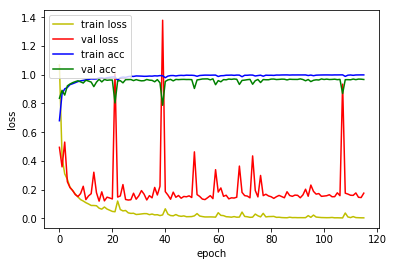

In [15]:
fig, ax = plt.subplots()
ax.plot(hist.history['loss'], 'y', label='train loss')
ax.plot(hist.history['val_loss'], 'r', label='val loss')
ax.plot(hist.history['acc'], 'b', label='train acc')
ax.plot(hist.history['val_acc'], 'g', label='val acc')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(loc='upper left')
plt.show()

png_path = 'visualization/learning_curve/'
filename = 'SampleCNN_8_conv_SGD'+'.png'
os.makedirs(png_path, exist_ok=True)
fig.savefig(png_path+filename, transparent=True)

In [16]:
del model

(6) Test

In [17]:
model_path = 'model/checkpoint/SampleCNN_8_conv_SGD_checkpoint/'
model_filename = model_path + sorted(os.listdir(model_path))[-1]
model = load_model(model_filename)
[loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
print('Loss:', loss, 'Accuracy:', accuracy)

4815/4815 [==============================] - 6s 1ms/step
Loss: 0.15826960811594565 Accuracy: 0.9511941848638026


In [ ]:
pred = model.predict(x_test)
test_f1_score = f1_score(y_test, pred > 0.5)
print('F1 Score:', test_f1_score)

In [ ]:
%timeit -n 5 -r 5 model.predict(x_test)